In [234]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import rasterio
import matplotlib.pyplot as plt
from time import time

<br>

### Reading GTSR data

From `https://www.geonode-gfdrrlab.org/layers` (accessed 26 April 2022)

In [76]:
gtsr_dir = "./gtsr_data/"

gtsr_rps = [2,5,10,25,50,100,250,500,1000]
gtsr_filenames = ["hazard__ss_muis_rp0002m.tif", "hazard__ss_muis_rp0005m.tif",
                  "hazard__ss_muis_rp0010m.tif", "hazard__ss_muis_rp0025m.tif",
                  "hazard__ss_muis_rp0050m.tif", "hazard__ss_muis_rp0100m.tif",
                  "hazard__ss_muis_rp0250m.tif", "hazard__ss_muis_rp0500m.tif",
                  "hazard__ss_muis_rp1000m.tif"]
src = rasterio.open(gtsr_dir+"hazard__ss_muis_rp0002m.tif")
dat = np.zeros((src.shape[0],src.shape[1],len(gtsr_rps)))

for r in range(len(gtsr_rps)):
    src = rasterio.open(gtsr_dir+gtsr_filenames[r])
    dat[:,:,r] = src.read(1)

<br>

### Read CIAM segment info

In [57]:
ciamdir = "/Users/aewsma/.julia/dev/MimiCIAM"
dfD = pd.read_csv(ciamdir+"/data/input/surgeexposure.csv")
segnames = dfD["segments"]
segmap = pd.read_csv(ciamdir+"/data/diva_segment_latlon.csv")

In [282]:
all(segmap["segments"] == dfD["segments"])

True

In [461]:
dfS = pd.read_excel("../DIVA_spreadsheet.xls")

In [462]:
dfS.head()

,SEGID,S1,S10,S100,S1000,BRF,SMAX,LONGI,LATI,SLOPECST,...,popadj,popadjin,ID_IV,sdikhgt,basinsid,test,CSVSN,popdn0,OID_,CSVSF
0,5106,0.412,0.512,0.612,0.712,0.0,3.712,-122.645,75.918,0.605,...,1.0,1,5105,0.0,-999.999,-999.999,4,0.000252,5105,3.80
1,5115,0.514,0.655,0.803,0.956,0.0,3.956,-121.031,75.891,0.840,...,1.0,1,5114,0.0,-999.999,-999.999,4,0.000252,5114,3.80
2,5120,0.319,0.419,0.519,0.619,1.0,3.619,-116.799,77.534,0.409,...,1.0,1,5119,0.0,-999.999,-999.999,4,0.000252,5119,3.57
3,5132,0.630,0.758,0.891,1.027,1.0,4.027,-118.191,75.968,1.332,...,1.0,1,5131,0.0,-999.999,-999.999,4,0.000252,5131,3.83
4,5166,0.965,1.087,1.213,1.341,0.1,4.341,-115.022,74.963,1.795,...,1.0,1,5165,0.0,-999.999,-999.999,4,0.000000,5165,4.00


<br>

### Get GTSR return levels for CIAM segments

Take an ever-expanding square that stops once nonzeros are found within it (so, necessarily on the perimeter since it's expanding). 

Switching the order here so that we loop over the segments on the outside. Since we'll find the closest ones and then can fill up all of the levels for that segment.

And apply the padding to the array of return levels right off the bat. Will need to offset the found i and j from the lat/lon lookup. 3000 was chosen for periodic padding since that finds the coast for all segments.

In [241]:
# just make a bigger dat array for padding

maxdx = 3000

datp = dat.copy()
print(datp.shape)
# pad along the spatial axes (first two), but not the return levels axis (axis=2)
# - padding along axis 0 at the "top"
padding = datp[-maxdx:,:,:]
datp = np.concatenate((padding,datp), axis=0)
# - padding along axis 0 at the "bottom"
padding = datp[:maxdx,:,:]
datp = np.concatenate((datp,padding), axis=0)
# - padding along axis 1 at the "front"
padding = datp[:,-maxdx:,:]
datp = np.concatenate((padding,datp), axis=1)
# - padding along axis 1 at the "back"
padding = datp[:,:maxdx,:]
datp = np.concatenate((datp,padding), axis=1)
print(datp.shape)

(16744, 43200, 9)
(22744, 49200, 9)


Quick testing:

In [357]:
tbeg = time()

gtsr_levs = np.zeros((len(segnames),datp.shape[2]))

#for s in range(len(segnames)):
#for s in range(100):
for s in [11425,11929]:

    # get this segment's lat and lon
    lat = float(segmap.loc[segmap["segments"]==segnames[s],"lati"])
    lon = float(segmap.loc[segmap["segments"]==segnames[s],"longi"])
    # find nonzero GTSR levels around this segment's centroid
    i,j = src.index(lon,lat) # j goes with lon, i goes with lat; (i,j) indexes into `dat`, i=row, j=col
    i += maxdx
    j += maxdx
    # first, find nonzero levs for highest return level
    # (since some of the lower levels are 0, but higher ones are nonzero)
    # then, use that maxdx for the other return levels
    r = len(gtsr_rps)-1
    levs = datp[i,j,r]
    if levs==0:
        # initialize for each segment
        dx = 0
        while (dx < maxdx) and (np.sum(levs!=0)==0):
            dx += 1
            levs = datp[i-dx:i+dx+1, j-dx:j+dx+1, r]
        if dx >= maxdx and np.sum(levs!=0)==0:
            print("s=",s,": search failed within maxdx=",maxdx)
        else:
            idx = np.where(levs > 0)
            for r in range(datp.shape[2]):
                levs = datp[i-dx:i+dx+1, j-dx:j+dx+1, r]
                gtsr_levs[s,r] = np.median([levs[x,y] for (x,y) in zip(idx[0],idx[1])])
    else:
        for r in range(datp.shape[2]):
            gtsr_levs[s,r] = datp[i,j,r]
                
tend = time()
print((tend-tbeg)/60,"minutes")

0.595045789082845 minutes


Now do it for all segments:

In [414]:
tbeg = time()

gtsr_levs = np.zeros((len(segnames),datp.shape[2]))

for s in range(len(segnames)):

    # get this segment's lat and lon
    lat = float(segmap.loc[segmap["segments"]==segnames[s],"lati"])
    lon = float(segmap.loc[segmap["segments"]==segnames[s],"longi"])
    # find nonzero GTSR levels around this segment's centroid
    i,j = src.index(lon,lat) # j goes with lon, i goes with lat; (i,j) indexes into `dat`, i=row, j=col
    i += maxdx
    j += maxdx
    # first, find nonzero levs for highest return level
    # (since some of the lower levels are 0, but higher ones are nonzero)
    # then, use that maxdx for the other return levels
    #r = len(gtsr_rps)-1
    r = 0
    levs = datp[i,j,r]
    if levs==0:
        # initialize for each segment
        dx = 0
        while (dx < maxdx) and (np.sum(levs!=0)==0):
            dx += 1
            levs = datp[i-dx:i+dx+1, j-dx:j+dx+1, r]
        if dx >= maxdx and np.sum(levs!=0)==0:
            print("s=",s,": search failed within maxdx=",maxdx)
        else:
            idx = np.where(levs > 0)
            for r in range(datp.shape[2]):
                levs = datp[i-dx:i+dx+1, j-dx:j+dx+1, r]
                gtsr_levs[s,r] = np.median([levs[x,y] for (x,y) in zip(idx[0],idx[1])])
    else:
        for r in range(datp.shape[2]):
            gtsr_levs[s,r] = datp[i,j,r]
                
tend = time()
print((tend-tbeg)/60,"minutes")

73.41729611555735 minutes


Write output file

In [418]:
dfG = pd.DataFrame({"segments" : segnames})
for r in range(len(gtsr_rps)):
    dfG["r"+str(gtsr_rps[r])] = gtsr_levs[:,r]
dfG.to_csv("dfG_gtsr.csv",index=False)

<br>

### Compute Gumbel parameters

For each data point, based on the GTSR return levels.

Using the 10- and 1000-year return levels for the fits and computing 100-year return level from the fitted Gumbel parameters.

In [362]:
ciam_rps = [1,10,100,1000,10000]

In [363]:
def fit_gumbel(xa,Fa,xb,Fb):
    sigma = (xa-xb)/(np.log(-np.log(Fb)) - np.log(-np.log(Fa)))
    mu = xa + sigma*np.log(-np.log(Fa))
    return (mu,sigma)

In [419]:
params_gumbel = np.zeros((len(segnames),2)) # columns are the mu and sigma parameters, rows are segments
x100 = np.zeros(len(segnames))
for s in range(len(segnames)):
    x10, x1000 = dfG.iloc[s][["r10","r1000"]]
    params_gumbel[s,:] = fit_gumbel(x10,0.9, x1000,0.999)
    x100[s] = stats.gumbel_r.ppf(1-1/100, loc=params_gumbel[s,0], scale=params_gumbel[s,1])

In [497]:
dfG_ciam = dfD.copy()

In [498]:
dfG_ciam["s10"] = dfG["r10"]
dfG_ciam["s100"] = x100
dfG_ciam["s1000"] = dfG["r1000"]
dfG_ciam["smax"] = dfS["SMAX"]

Yeah, this ends up not making much of a difference. At least it's using a Gumbel, which is nice.

In [499]:
np.corrcoef(dfG.r100,dfG_ciam.s100)

array([[1.        , 0.99999547],
       [0.99999547, 1.        ]])

<br>

### `s1` correction

Can't get the "1-year return level", so apply a correction based on the difference between the GTSR 10-y return level and the DINAS-COAST level.

In [500]:
factor = dfG_ciam.s10/dfS.S100
dfG_ciam["s1"] = dfS.S1*factor

In [503]:
dfG_ciam.head()

,segments,s1,s10,s100,s1000,smax
0,Canada5106,0,0.238562,0.405074,0.568562,3.220562
1,Canada5115,0,0.262727,0.429239,0.592727,3.488727
2,Canada5120,0,0.281310,0.447822,0.611310,3.170310
3,Canada5132,0,0.213838,0.380350,0.543838,3.510838
4,Canada5166,0,0.149250,0.315762,0.479250,3.760250


<br>

### Nomalize relative to `s1`

Expected CIAM inputs

In [502]:
dfG_ciam.s10 = dfG_ciam.s10 - dfG_ciam.s1
dfG_ciam.s100 = dfG_ciam.s100 - dfG_ciam.s1
dfG_ciam.s1000 = dfG_ciam.s1000 - dfG_ciam.s1
dfG_ciam.smax = dfG_ciam.smax - dfG_ciam.s1
dfG_ciam.s1 = 0

<br>

### Write new forcing file

In [504]:
dfG_ciam.to_csv("surgeexposure_gtsr.csv", index=False)

<br>

---

<br>

# _Potentially useful code and notes to save_


`src.transform * (i, j) = (x, y)`, where `(i, j)` are the row and column indices within the data array, and `(x, y)` are the longitude and latitude coordinates of that data point on the globe.

`(0,0)` starts at lon = -180 deg E and lat = 83.6... deg N

`(1,0)` is slightly further east at lon = -179.99 deg E and same lat

first coordinate (lon) runs from -180 to 180, from indices 0 to 43200

second coordinate (lat) runs from +83.6... deg N to -55.9... deg N, from indices 0 to 16744

In [212]:
src.transform * (10, 10)

(-179.9166666623205, 83.5416739394672)

In [48]:
src.transform * (43200, 16744)

(180.00001877546288, -55.90833333341696)

NYC: 40.7128° N, 74.0060° W

In [51]:
src.transform * (int(43200*(-74.0060--180)/360), int(16744*(83.6-40.7128)/(83.6--55.9)))

(-74.00832780543722, 40.73333837350533)

In [52]:
(int(43200*(-74.0060--180)/360), int(16744*(83.6-40.7128)/(83.6--55.9)))

(12719, 5147)

In [113]:
src.transform * (12717,5155)

(-74.02499447297312, 40.66667170336173)

In [205]:
src.index(lon,lat) # j goes with lon, i goes with lat; (i,j) indexes into `dat`, i=row, j=col

(924, 6882)

In [208]:
src.index(lon+1,lat+1) # j goes with lon, i goes with lat; (i,j) indexes into `dat`, i=row, j=col

(804, 7002)

In [209]:
lat, lon

(75.918, -122.645)

`(i,j = src.index(lon,lat)`

As lat increases, `i` decreases. As lon increases, `j` decreases...

`src.transform * (0, 0) = (-180.0, 83.625)`

Indexing starts in the upper left of a map from -180 to 180 lon x -90 to 90 lat.

`src.transform * (10, 0) = (-179.917, 83.625)`

Then as first index increases, move from west to east

`src.transform * (10, 10) = (-179.917, 83.542)`

And as second index increases, move from north to south

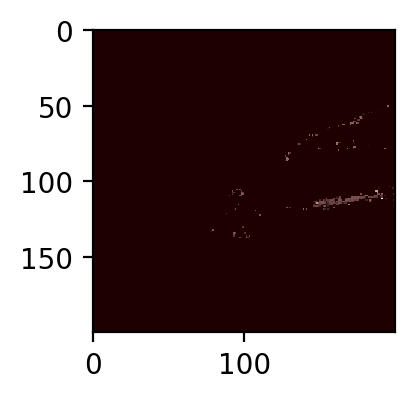

In [8]:
dx = 100
plt.figure(figsize=(2,2), dpi=200)
plt.imshow(dat100[5147-dx:5147+dx,12719-dx:12719+dx], cmap="pink");

## Computing the parameters of the Gumbel distribution for a particular point.

Gumbel cdf:

$$F(x) = e^{-e^{-\dfrac{x-\mu}{\sigma}}}$$

Have a bunch of return levels. e.g., If $x_{10}$ is the 10-year return level, then $F(x_{10}) = 0.9$.

Solving for $\mu$ gives:

$$\mu = x + \sigma \log{[-\log{(F(x))}]}$$

Plugging in two data points $x_a$ and $x_b$ (two different return levels) gives:

$$\mu = x_a + \sigma \log{[-\log{(F(x_a))}]} = x_b + \sigma \log{[-\log{(F(x_b))}]}$$

Rearranging and solving for $\sigma$ gives:

$$\sigma = \dfrac{x_a - x_b}{\log{[-\log{(F(x_b))}]}-\log{[-\log{(F(x_a))}]}}$$

Then we plug back into the above equation for $\mu$ to solve for the location parameter.